This is a usage example for the FMAE Python library based on the paper

"Hierarchical Fuzzy Model-Agnostic Explanation: Framework, Algorithms and Interface for XAI" [1]

https://ieeexplore.ieee.org/document/10731553

Authors: Faliang Yin, Hak-Keung Lam, David Watson

In [1]:
import numpy as np
from sklearn.neural_network import MLPRegressor, MLPClassifier
from fmae import forward_selection, FmaeExplainer
from fmae import plot_feature_salience, print_rules
from sklearn import model_selection

def load_dataset_from_csv(file_path, num_features=5, random_state=1):
    dataset = np.loadtxt(file_path, delimiter=",", skiprows=0)
    sam, label = dataset[:, :-1], dataset[:, -1].reshape(-1, 1)
    fea_idx = forward_selection(sam, label, weights=None, num_features=5, random_state=random_state)
    sam = sam[:, fea_idx]
    train, test, labels_train, _ = \
        model_selection.train_test_split(sam, label, train_size=0.80, random_state=random_state)
    return train, test, labels_train, fea_idx

Step 1. Load your dataset (Breast Cancer Wisconsin (Original) [2] dataset in this example).

In [2]:
dataset_name = 'WBC'
mode = 'classification'
feature_names = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion',
                 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']
class_names = ['Benign', 'Malignant']

np.random.seed(0)
train, test, labels_train, fea_idx = load_dataset_from_csv('WBC.csv', random_state=0)
selected_fea_names = [feature_names[i] for i in fea_idx]

Step 2. Prepare your black-box model that you want to explain (here we train a black-box model based on MLP).

In [3]:
if mode == 'classification':
    model = MLPClassifier(max_iter=1000)  # closed box (black box) classifier
else:
    model = MLPRegressor(max_iter=1000)
model.fit(train, labels_train.ravel())

MLPClassifier(max_iter=1000)

Step 3. Initialize FMAE explainer by providing the black-box model and the dataset. Please note that if your black-box model is a classifier, you should provide the function to get the prediction probabilities.

Then, input your instance of interest to the explain() method of the explainer. In this example, we generate a local explanation for the first instance in the test set.

In [4]:
if mode == 'classification':
    explainer = FmaeExplainer(model.predict_proba, np.concatenate((train, test), axis=0), mode=mode)
else:
    explainer = FmaeExplainer(model.predict, np.concatenate((train, test), axis=0), mode=mode)
feature_weights = explainer.explain(np.expand_dims(test[0], axis=0))

Step 4. Print out the explanation results, including the IF-THEN rules, and feature salience plots.

R2 score on training set: 0.9973500130311235
r1: IF Bare Nuclei is medium, Normal Nucleoli is medium, THEN predicted as Benign with 0.972, Malignant with 0.023;
r2: IF Bare Nuclei is medium, Normal Nucleoli is low, THEN predicted as Benign with 1.003, Malignant with 0.004;
r3: IF Bare Nuclei is high, Normal Nucleoli is medium, THEN predicted as Benign with 0.839, Malignant with 0.170;
r4: IF Bare Nuclei is medium, Uniformity of Cell Size is low, Normal Nucleoli is medium, THEN predicted as Benign with 0.986, Malignant with 0.010;
r5: IF Bare Nuclei is medium, Uniformity of Cell Size is high, Normal Nucleoli is medium, THEN predicted as Benign with 0.866, Malignant with 0.130;
r6: IF Bare Nuclei is medium, Clump Thickness is high, Normal Nucleoli is medium, THEN predicted as Benign with 0.879, Malignant with 0.112;
r7: IF Bare Nuclei is medium, Normal Nucleoli is medium, Bland Chromatin is low, THEN predicted as Benign with 0.967, Malignant with 0.010;
r8: IF Bare Nuclei is medium, Norm

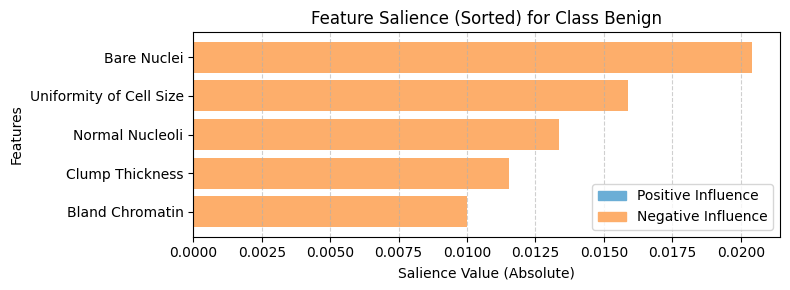

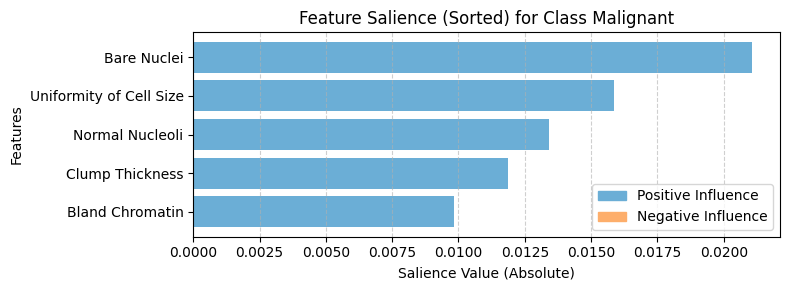

In [5]:
print(f'R2 score on training set: {explainer.score}')
print_rules(explainer.rule_bases[0], 3, explainer.d_scores[0], feature_list=selected_fea_names, class_list=class_names)
plot_feature_salience(feature_weights[0, :, 0], absolute_mode=True, title_note=f'for Class {class_names[0]}', feature_names=np.array(selected_fea_names), )
plot_feature_salience(feature_weights[0, :, 1], absolute_mode=True, title_note=f'for Class {class_names[1]}', feature_names=np.array(selected_fea_names))

References

[1] F. Yin, H. -K. Lam and D. Watson, "Hierarchical Fuzzy Model-Agnostic Explanation: Framework, Algorithms, and 
Interface for XAI," in IEEE Transactions on Fuzzy Systems, vol. 33, no. 2, pp. 549-558, Feb. 2025, 
doi: 10.1109/TFUZZ.2024.3485212.

[2] W. Wolberg, O. Mangasarian, N. Street, and W. Street. "Breast Cancer Wisconsin (Diagnostic)," 
UCI Machine Learning Repository, 1993. [Online]. Available: https://doi.org/10.24432/C5DW2B.